# Exploratory Analysis of Billboard Chart Data

For the soul purpose of aimlessly wandering through Billboard data to see what might be worth discovery.

Data is collected using [Allen Guo](http://aguo.us/)'s [billboard.py](https://pypi.org/project/billboard.py/) package (thanks, yo!) which scrapes chart data from Billboard.com. As of right now, I am sticking with the Hot 100 chart for all weeks in 2018. The data is scraped, organized, the date is cast to `datetime64[ns]`, and everything is pickled for future uses without requiring it all be re-downloaded.

In [19]:
#
# SKIP THIS CELL UNLESS THE DATA
# NEEDS TO BE RE-DOWNLOADED C=
#

import billboard
import numpy as np
import pandas as pd

_CHART = 'hot-100'
rows_list = []

chart = billboard.ChartData(_CHART, date='2018-12-29')
while chart.date > '2018':
    for track in chart:
        rows_list.append({'date': chart.date,
                          'rank': track.rank,
                          'artist': track.artist,
                          'title': track.title,
                          'is_new': track.isNew,
                          'rank_last_week': track.lastPos,
                          'rank_peak_current': track.peakPos,
                          'consec_weeks_current': track.weeks})
    
    chart = billboard.ChartData(_CHART, chart.previousDate)

df = pd.DataFrame(rows_list)
df['date'] = df['date'].astype('datetime64')

df.to_pickle('./2018-hot-100.pkl')

In [21]:
#
# START HERE IF YOU DON'T NEED
# TO RE-DOWNLOAD THE DATA C=
#

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

df = pd.read_pickle('./2018-hot-100.pkl')

df.dtypes

artist                          object
consec_weeks_current             int64
date                    datetime64[ns]
is_new                            bool
rank                             int64
rank_last_week                   int64
rank_peak_current                int64
title                           object
dtype: object

With very few uses for each observation of an individual track as unique to every other of its observations, I decided to group the dataframe by both the `artist` and `title` columns and store the `DataFrameGroupBy` object for further use as necessary.

In [23]:
artist_title_group = df.groupby(['artist','title'])

The data returned by `billboard.py` is only what is able to be scraped off the chart each week. The values in `consec_weeks_current` and `rank_peak_current` are only the number of consecutive weeks and it's highest rank, respectively, for any given track *as of the current week*. I created new columns, `consec_weeks_overall` and `rank_peak_overall`, to store the value of the tracks' consecutive weeks and highest rank on the chart overall (within 2018).

In [14]:
df['consec_weeks_overall'] = artist_title_group['consec_weeks_current'].transform(max)
df['rank_peak_overall'] = artist_title_group['rank_peak_current'].transform(min)

df[['date',
    'rank',
    'consec_weeks_current',
    'consec_weeks_overall',
    'rank_peak_current',
    'rank_peak_overall']].tail()

,date,rank,consec_weeks_current,consec_weeks_overall,rank_peak_current,rank_peak_overall
5295,2018-01-03,96,3,20,95,44
5296,2018-01-03,97,9,12,66,66
5297,2018-01-03,98,2,37,61,6
5298,2018-01-03,99,5,20,91,52
5299,2018-01-03,100,3,12,98,68


In [15]:
df.describe()

,consec_weeks_current,rank,rank_last_week,rank_peak_current,consec_weeks_overall,rank_peak_overall
count,5300.000000,5300.000000,5300.000000,5300.000000,5300.000000,5300.000000
mean,11.483774,50.500000,39.719057,36.685283,19.416226,31.264340
std,10.077840,28.868794,30.261335,28.355576,12.181646,25.562746
min,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000
25%,4.000000,25.750000,12.000000,10.000000,10.000000,8.000000
50%,9.000000,50.500000,37.000000,33.000000,20.000000,27.000000
75%,17.000000,75.250000,65.000000,58.000000,24.000000,51.000000
max,59.000000,100.000000,100.000000,100.000000,59.000000,100.000000


In [18]:
df['consec_weeks_overall'].unique()

array([ 7, 11, 20,  9, 18, 29, 10, 14, 26, 24, 30, 17, 16, 23, 34,  3, 32,
        1, 12,  8,  2,  4, 15, 44, 37, 22, 19,  6,  5, 13, 38, 35, 41, 39,
       40, 27, 52, 57, 25, 36, 21, 46, 48, 31, 54, 28, 45, 33, 59, 42],
      dtype=int64)

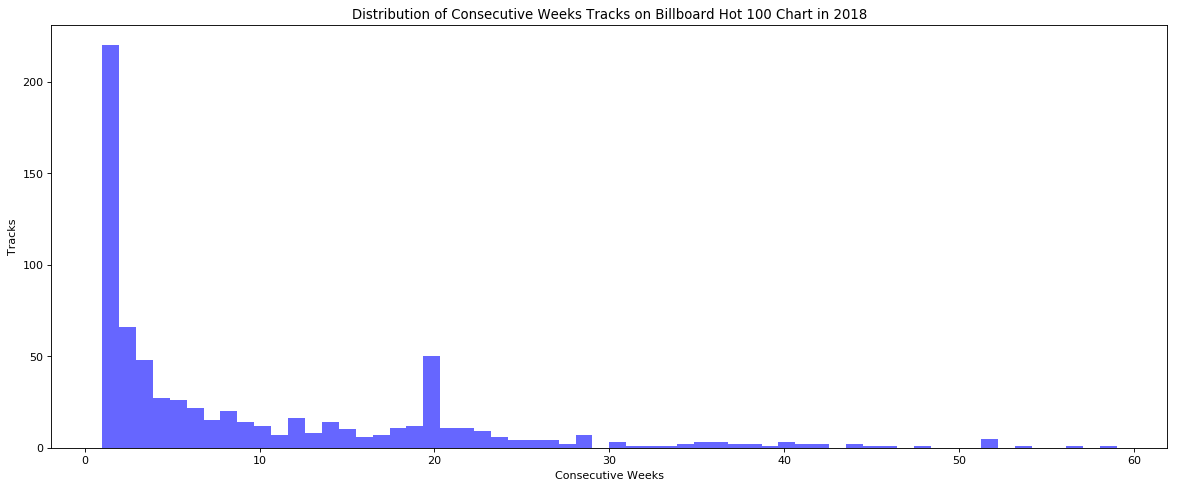

In [7]:
consec_weeks_overall_plt = artist_title_group[['consec_weeks_overall']].first()

plt.figure(figsize=(18, 7), dpi= 80, facecolor='w', edgecolor='k')
consec_weeks_overall_plt['consec_weeks_overall'].plot.hist(bins=60, color='b', alpha=0.6)

plt.xlabel('Consecutive Weeks')
plt.ylabel('Tracks')
plt.title('Distribution of Consecutive Weeks Tracks on Billboard Hot 100 Chart in 2018')
plt.grid(False)
plt.show()

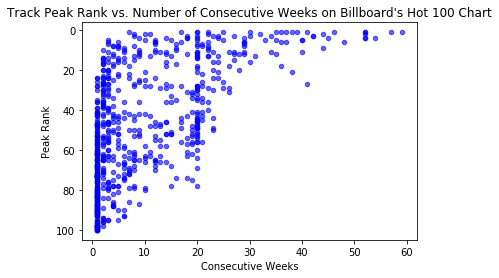

In [8]:
peaks_vs_weeks_plt = artist_title_group[['rank_peak_overall', 'consec_weeks_overall']].first()

peaks_vs_weeks_plt.plot.scatter(x='consec_weeks_overall', y='rank_peak_overall', color='b', alpha=0.6)

plt.xlabel('Consecutive Weeks')
plt.ylabel('Peak Rank')
plt.title('Track Peak Rank vs. Number of Consecutive Weeks on Billboard\'s Hot 100 Chart')
plt.gca().invert_yaxis()
plt.grid(False)
plt.show()